In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [2]:
# Umgebung einrichten
env = gym.make("FrozenLake-v1", is_slippery=True)

In [3]:
# Hilfsfunktion
def one_hot_encode(state, size):
    vec = np.zeros(size)
    vec[state] = 1.0
    return vec

In [ ]:
# DQN Modell
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
# DQNAgent-Klasse
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.999, buffer_size=10000, batch_size=64, update_target_every=10, ddqn=False):
        self.state_dim, self.action_dim, self.gamma, self.epsilon, self.epsilon_min, self.epsilon_decay, self.batch_size, self.update_target_every, self.ddqn = state_dim, action_dim, gamma, epsilon, epsilon_min, epsilon_decay, batch_size, update_target_every, ddqn
        self.memory = deque(maxlen=buffer_size)
        
        # Es wird immer das Standard-DQN-Modell verwendet
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.update_target_network()
        self.train_step_counter = 0

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_dim)
        
        state_t = torch.tensor(state, dtype=torch.float32)
        # Füge eine Batch-Dimension hinzu: [state_dim] -> [1, state_dim]
        state_t = state_t.unsqueeze(0) 
        
        with torch.no_grad():
            # Das Modell empfängt einen 2D-Tensor
            q_values = self.model(state_t)
            
        # q_values hat die Form [1, action_dim], argmax funktioniert korrekt
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return None
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states_t = torch.tensor(np.array(states), dtype=torch.float32)
        actions_t = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1)
        rewards_t = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        next_states_t = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones_t = torch.tensor(dones, dtype=torch.bool).unsqueeze(-1)
        
        with torch.no_grad():
            if self.ddqn:
                # Double DQN: Aktionen vom Online-Netzwerk, Werte vom Ziel-Netzwerk
                best_next_actions = self.model(next_states_t).argmax(1).unsqueeze(-1)
                next_q_values = self.target_model(next_states_t).gather(1, best_next_actions)
            else:
                # Standard DQN: Werte vom Ziel-Netzwerk
                next_q_values = self.target_model(next_states_t).max(1)[0].unsqueeze(-1)
            
            # Q-Wert für Endzustände ist 0
            next_q_values[dones_t] = 0.0
        
        # Berechnung der Ziel-Q-Werte (Target Q-Values)
        target_q_values = rewards_t + self.gamma * next_q_values
        
        # Berechnung der aktuellen Q-Werte (Current Q-Values)
        current_q_values = self.model(states_t).gather(1, actions_t)
        
        # Verlustberechnung und Optimierung
        loss = nn.MSELoss()(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.train_step_counter += 1
        if self.train_step_counter % self.update_target_every == 0:
            self.update_target_network()
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        return loss.item()

In [ ]:
def train_agent(num_episodes, agent_type="dqn", agent_params={}):
    state_dim, action_dim = env.observation_space.n, env.action_space.n
    is_ddqn = 'ddqn' in agent_type
    
    agent = DQNAgent(state_dim, action_dim, ddqn=is_ddqn, **agent_params)
    episode_rewards, episode_losses = [], []
    
    for episode in range(num_episodes):
        state_int, _ = env.reset()
        state = one_hot_encode(state_int, state_dim)
        total_reward, step_losses = 0, []
        
        for step in range(100):
            action = agent.act(state)
            next_state_int, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = one_hot_encode(next_state_int, state_dim)
            agent.remember(state, action, reward, next_state, done)
            
            loss = agent.replay()
            if loss is not None:
                step_losses.append(loss)
                
            state = next_state
            total_reward += reward
            if done: break
            
        episode_rewards.append(total_reward)
        episode_losses.append(np.mean(step_losses) if step_losses else 0)
        
        if (episode + 1) % 500 == 0:
            print(f"Agent: {agent_type.upper()} | Ep {episode+1}/{num_episodes} | Avg Loss: {episode_losses[-1]:.4f} | Epsilon: {agent.epsilon:.3f}")
            
    return episode_rewards, episode_losses

In [7]:
def plot_comparison(results_dict, window_size=100):
    plt.figure(figsize=(12, 8))
    for agent_name, all_rewards in results_dict.items():
        mean_rewards = np.mean(all_rewards, axis=0)
        std_rewards = np.std(all_rewards, axis=0)
        smooth_mean = np.convolve(mean_rewards, np.ones(window_size) / window_size, mode="valid")
        smooth_std = np.convolve(std_rewards, np.ones(window_size) / window_size, mode="valid")
        label_map = {"dqn": "Standard DQN", "ddqn": "Double DQN"}
        plt.plot(range(len(smooth_mean)), smooth_mean, label=f"{label_map.get(agent_name, agent_name)} (Mittlere Belohnung)")
        plt.fill_between(range(len(smooth_mean)), smooth_mean - smooth_std, smooth_mean + smooth_std, alpha=0.2)
    plt.title("Vergleich der Belohnung (Erfolgsrate) auf Frozen Lake", fontsize=16)
    plt.xlabel(f"Episode (geglättet über {window_size} Episoden)", fontsize=12)
    plt.ylabel("Durchschnittliche Erfolgsrate (Belohnung)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("dqn_reward_comparison_frozenlake.png")
    plt.show()

def plot_loss(results_dict, window_size=100):
    plt.figure(figsize=(12, 8))
    for agent_name, all_losses in results_dict.items():
        mean_losses = np.mean(all_losses, axis=0)
        smooth_mean = np.convolve(mean_losses, np.ones(window_size) / window_size, mode="valid")
        label_map = {"dqn": "Standard DQN", "ddqn": "Double DQN"}
        plt.plot(range(len(smooth_mean)), smooth_mean, label=f"{label_map.get(agent_name, agent_name)} Verlust")
    plt.title("Vergleich des Trainingsverlusts (MSE) auf Frozen Lake", fontsize=16)
    plt.xlabel(f"Episode (geglättet über {window_size} Episoden)", fontsize=12)
    plt.ylabel("Durchschnittlicher Verlust (Mittlerer quadratischer Fehler)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("dqn_loss_comparison_frozenlake.png")
    plt.show()

In [8]:
NUM_EPISODES = 5000
NUM_RUNS = 3
frozen_lake_params = {'lr': 1e-4, 'gamma': 0.99, 'epsilon': 1.0, 'epsilon_min': 0.05, 'epsilon_decay': 0.9999, 'buffer_size': 10000, 'batch_size': 128, 'update_target_every': 20}

# Zu vergleichende Agententypen (ohne Dueling DQN)
agent_types_to_compare = ["dqn", "ddqn"]
all_results_rewards = {}
all_results_losses = {}

for agent_name in agent_types_to_compare:

    runs_rewards, runs_losses = [], []
    for i in range(NUM_RUNS):
        print(f"\nDurchlauf {i+1}/{NUM_RUNS}")
        # Seeds setzen für Reproduzierbarkeit
        np.random.seed(i); random.seed(i); torch.manual_seed(i); env.reset(seed=i)
        rewards, losses = train_agent(NUM_EPISODES, agent_type=agent_name, agent_params=frozen_lake_params)
        runs_rewards.append(rewards)
        runs_losses.append(losses)
    all_results_rewards[agent_name] = np.array(runs_rewards)
    all_results_losses[agent_name] = np.array(runs_losses)


Durchlauf 1/3
Agent: DQN | Ep 500/5000 | Avg Loss: 0.0015 | Epsilon: 0.661
Agent: DQN | Ep 1000/5000 | Avg Loss: 0.0119 | Epsilon: 0.361
Agent: DQN | Ep 1500/5000 | Avg Loss: 0.0124 | Epsilon: 0.131
Agent: DQN | Ep 2000/5000 | Avg Loss: 0.0061 | Epsilon: 0.050
Agent: DQN | Ep 2500/5000 | Avg Loss: 0.0065 | Epsilon: 0.050
Agent: DQN | Ep 3000/5000 | Avg Loss: 0.0059 | Epsilon: 0.050
Agent: DQN | Ep 3500/5000 | Avg Loss: 0.0054 | Epsilon: 0.050
Agent: DQN | Ep 4000/5000 | Avg Loss: 0.0061 | Epsilon: 0.050
Agent: DQN | Ep 4500/5000 | Avg Loss: 0.0059 | Epsilon: 0.050
Agent: DQN | Ep 5000/5000 | Avg Loss: 0.0069 | Epsilon: 0.050

Durchlauf 2/3
Agent: DQN | Ep 500/5000 | Avg Loss: 0.0088 | Epsilon: 0.640
Agent: DQN | Ep 1000/5000 | Avg Loss: 0.0126 | Epsilon: 0.316
Agent: DQN | Ep 1500/5000 | Avg Loss: 0.0083 | Epsilon: 0.097
Agent: DQN | Ep 2000/5000 | Avg Loss: 0.0057 | Epsilon: 0.050
Agent: DQN | Ep 2500/5000 | Avg Loss: 0.0062 | Epsilon: 0.050
Agent: DQN | Ep 3000/5000 | Avg Loss: 0.00

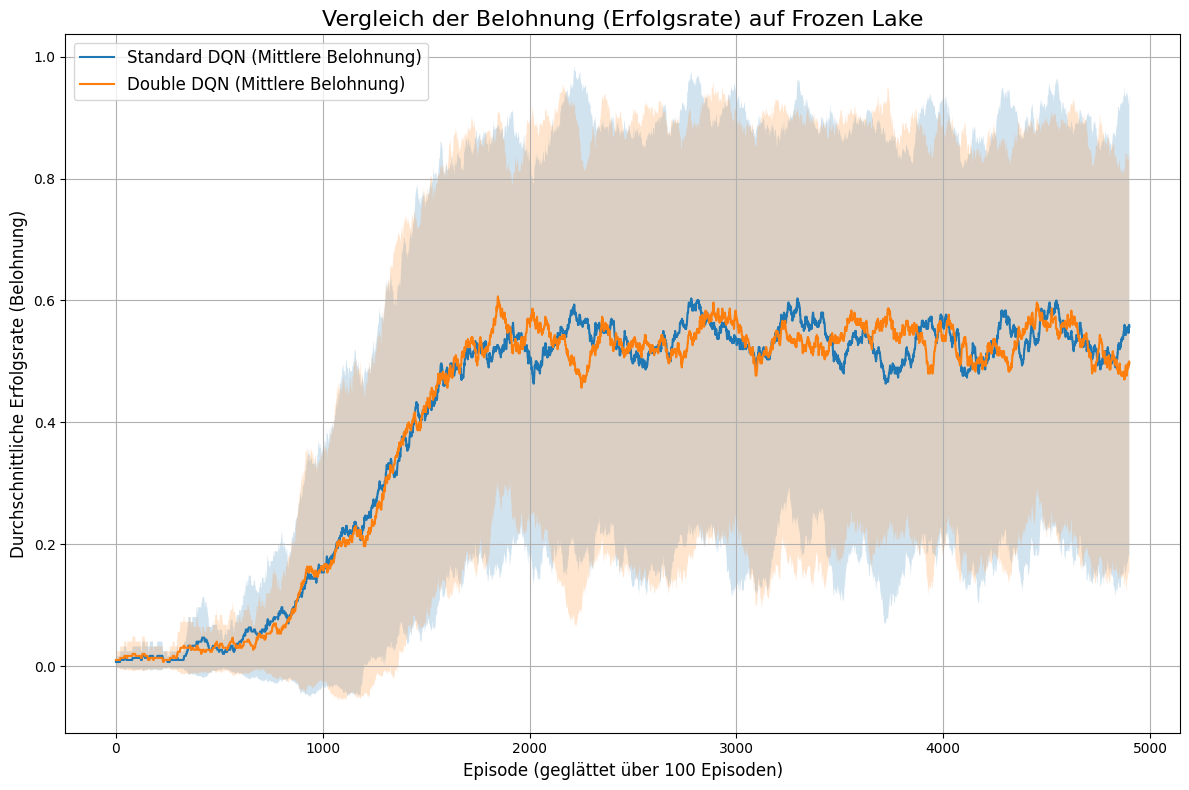

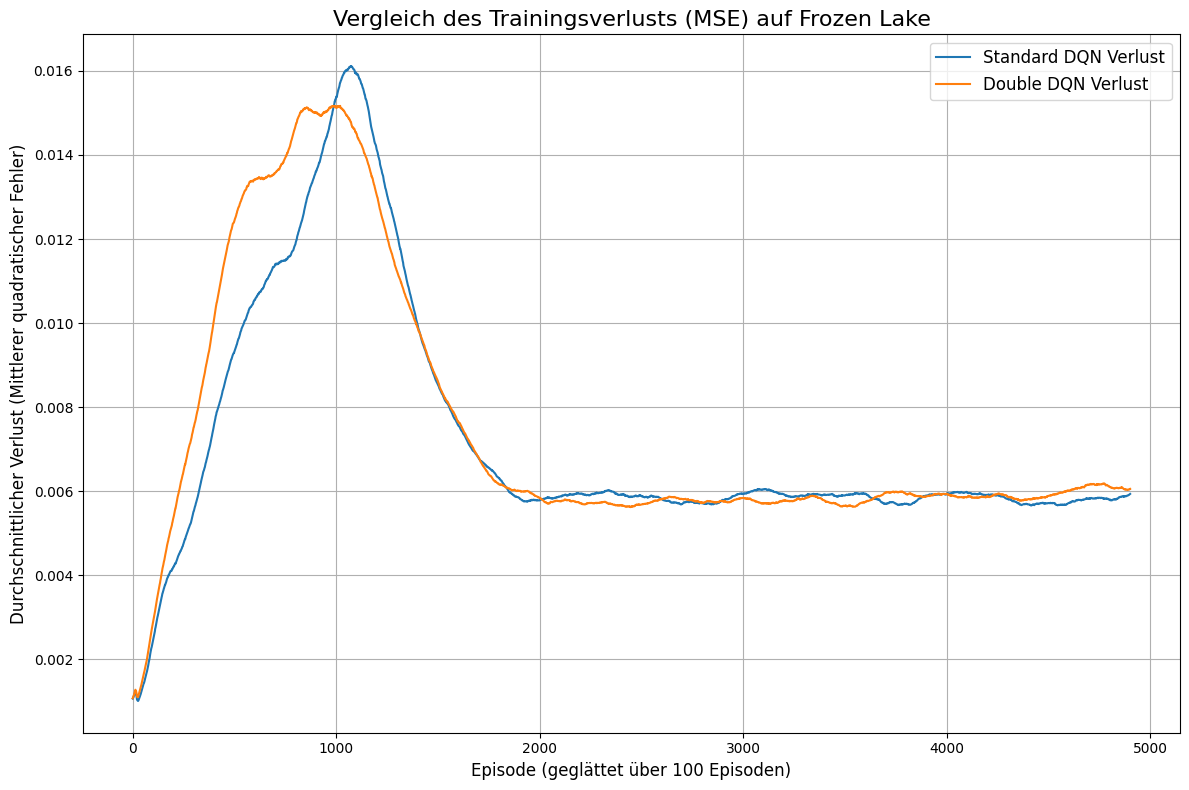

In [9]:
plot_comparison(all_results_rewards)
plot_loss(all_results_losses)